In [1]:
%matplotlib inline

import os
import warnings
import collections
import time
import datetime

from datetime import timedelta

import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates

import pandas as pd
import numpy as np
import seaborn as sns

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH '] = '1'

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

from pandas.plotting import register_matplotlib_converters

import util_functions as util
import options

register_matplotlib_converters()
sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

warnings.filterwarnings('ignore')

# show gpu status, fix memory growth
tf.debugging.set_log_device_placement(False)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:

    try:

        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "physical GPUs,", len(logical_gpus), "logical GPUs", logical_gpus)

    except RuntimeError as e:
        print(e)

print( 'tf version :', tf.__version__ )
print( 'tfp version:', tfp.__version__ )


tf version : 2.2.0
tfp version: 0.9.0


In [2]:
# mark is the current cost (e.g., original purchase price or averaged purchase price)
mark = 15

# underlying asset is SLV, looking at only $0 ... $30
slv = np.arange(30)

# call_strike for the weekly
call_strike_price = mark

# put_strike for the hedge
# long range expiration (two years)
put_strike_price = mark

# simple conditional equations for call and put
def call( x, strike ):
    y = np.where( x < strike, 0., x - strike )
    return y

def put( x, strike ):
    y = np.where( x < strike, -1 * (x - strike), 0. )
    return y


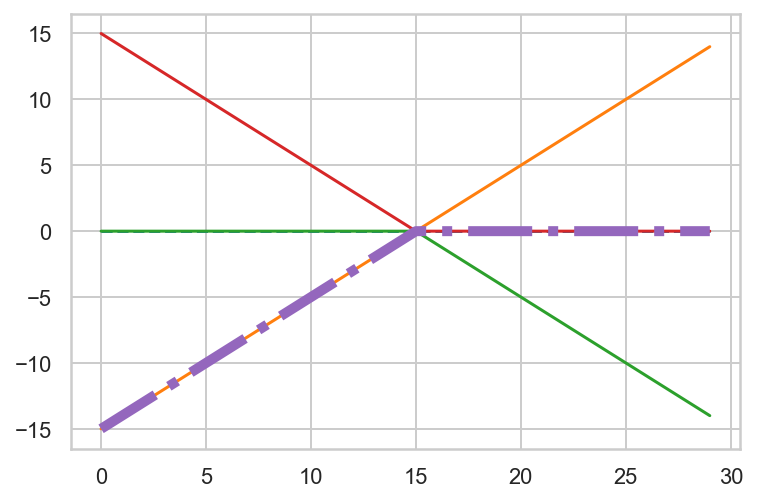

In [3]:

# plot break-even (zero) line
_ = plt.plot( np.arange(30), np.arange(30) * 0., linestyle="--" )

# plot profit vs range of SLV
_ = plt.plot( slv - mark )

# plot profit vs range of sold call (i.e., not purchased) 
_ = plt.plot( -1 * call( slv, call_strike_price ) )

# plot profit vs range of bought put hedge
_ = plt.plot( put( slv, put_strike_price ) )

# plot sum of hedge and underlying
#_ = plt.plot( ( slv - mark ) + put( slv, put_strike_price ), linestyle="--", linewidth=5  )

# plot sum of sold call and underlying
_ = plt.plot( ( slv - mark ) - call( slv, call_strike_price ), linestyle="-.", linewidth=5  )

# plot sum of all
#_ = plt.plot( ( slv - mark ) - call( slv, call_strike_price ) + put( slv, put_strike_price ), linestyle="-.", linewidth=5 )


In [6]:
# american( option_type, fs, x, t, r, q, v )
#
# Inputs:
#    option_type = "p" or "c"
#    fs          = price of underlying
#    x           = strike
#    t           = time to expiration
#    v           = implied volatility
#    r           = risk free rate
#    q           = dividend payment
#    b           = cost of carry
#
# Outputs: 
#    value       = price of the option
#    delta       = first derivative of value with respect to price of underlying
#    gamma       = second derivative of value w.r.t price of underlying
#    theta       = first derivative of value w.r.t. time to expiration
#    vega        = first derivative of value w.r.t. implied volatility
#    rho         = first derivative of value w.r.t. risk free rates

price = 15
strike = 15
call_expire_time = 30
hedge_expire_time = 623

# sell the call, buy the hedge
call = options.american( "c", price, strike, call_expire_time / 365, 0.01, 0.0, 0.25 )
hedge_beg = options.american( "p", price, strike, hedge_expire_time / 365, 0.01, 0.0, 0.25 )

# if the hedge_end is 15.85 weeks from hedge_beg, the time-value equals the profit of a single week. 
# i.e., set it to something much less than 15.85 weeks. e.g., 10 weeks (costs ~0.10 for full 10)
#       or est. 7 days costs about 1/10 of the full 10 weeks (so it's used here)
hedge_end = options.american( "p", price+0.425, strike, (hedge_expire_time-call_expire_time) / 365, 0.01, 0.0, 0.25 )
hedge_costs = hedge_beg[0] - hedge_end[0]

# worst case, pay for a put and a call on both enter and leave, or 4x
commission = ( ( .65 / 100 ) * 4 )

print( 'call,           ', call[0] )
print( 'hedge begin,    ', hedge_beg[0] )
print( 'hedge end,      ', hedge_end[0] )
print( 'costs' )
print( '  hedge,        ', hedge_costs )
print( '  commission,   ', commission )
print( 'profit,         ', call[0] - commission - hedge_costs )

print( 'greeks          ', call )

call,            0.4348215770575452
hedge begin,     1.8220412380253963
hedge end,       1.6086660093964067
costs
  hedge,         0.2133752286289896
  commission,    0.026000000000000002
profit,          0.19544634842855557
greeks           (0.4348215770575452, 0.5188645418076392, 0.37066254116831177, -2.6797024580902624, 1.7136795567713041, 0.6039572506896199)


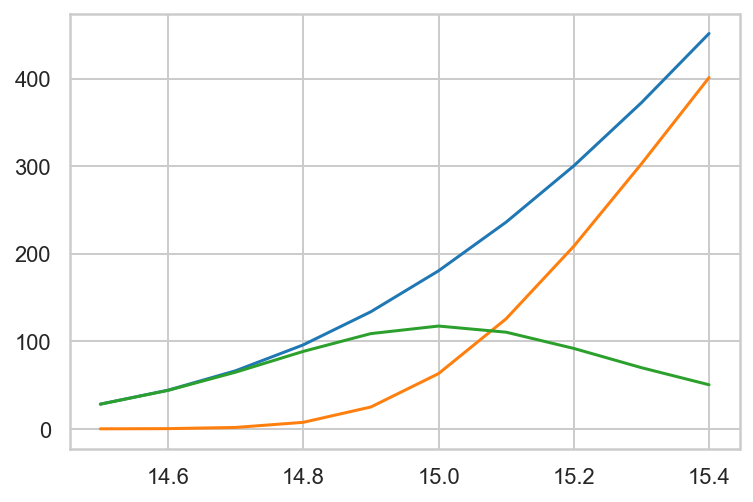

In [5]:
slv = np.arange( start = 14.5, stop = 15.5, step = 0.1 )

value_in = []
value_out = []
value_diff = []

for i in slv:

    call_in = options.american( "c", i, 15, 8/365, 0.02, 0.0, 0.2 )
    call_out = options.american( "c", i, 15, 1/365, 0.02, 0.0, 0.2 )
    
    value_in.append( call_in[0] * 100 * 10 )
    value_out.append( call_out[0] * 100 * 10 )
    value_diff.append( ( call_in[0] - call_out[0] ) * 100 * 10 )

_ = plt.plot( slv, value_in )
_ = plt.plot( slv, value_out )
_ = plt.plot( slv, value_diff )